<a href="https://colab.research.google.com/github/Gmurad735/nlp/blob/main/practice02_CNN_for_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 02: Dealing with texts using CNN

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/logos/front_page.png" width=400px>

Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). _Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# Do this only once
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145    0   145    0     0    297      0 --:--:-- --:--:-- --:--:--   296
100   320  100   320    0     0    388      0 --:--:-- --:--:-- --:--:--   388
100  119M  100  119M    0     0  37.4M      0  0:00:03  0:00:03 --:--:-- 67.3M
Train_rev1.csv


In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [4]:
data.head(1)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [5]:
data.columns

Index(['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized',
       'ContractType', 'ContractTime', 'Company', 'Category', 'SalaryRaw',
       'SalaryNormalized', 'SourceName'],
      dtype='object')

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

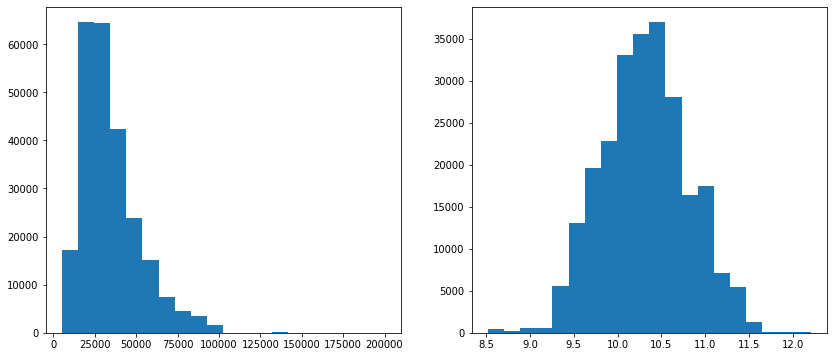

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[14, 6])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
197134,71834514,Marketing Manager – Superb retail catering bus...,Marketing Manager Superb retail catering busin...,UK,UK,NaN,NaN,Corecruitment International,Other/General Jobs,"50,000-74,999 yearly",62499,theladders.co.uk,11.042922
166171,71296243,Staff Nurse RGN Droitwich **** p/h Days,SYK Recruitment Specialists are looking for a ...,"Droitwich, West Midlands",Droitwich,NaN,permanent,SYK Recruitment,Healthcare & Nursing Jobs,12/hour,23040,cv-library.co.uk,10.045031
130958,70175103,Gardener/Handyperson (relief),We are looking for a Gardener/Handyperson to p...,Hertford,Hertford,part_time,NaN,WRVS.,Customer Services Jobs,6.38 - 7.07 per hour,12912,Jobcentre Plus,9.465990


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [8]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [9]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
def normalize(text):
    # <YOUR CODE HERE>
    text = str(text).lower()
    tokens = tokenizer.tokenize(text)
    
    return " ".join(tokens)
    
data[text_columns] = data[text_columns].applymap(normalize)

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter
from tqdm import tqdm as tqdm

token_counts = Counter()# <YOUR CODE HERE>

# hint: you may or may not want to use collections.Counter

In [ ]:
# two code for comparisons
# first

In [ ]:
%%time

for _, row in data[text_columns].iterrows():
    for text in row:
        token_counts.update(text.split(" "))

CPU times: user 58.2 s, sys: 291 ms, total: 58.5 s
Wall time: 1min 3s


In [12]:
# second
token_counts_second = Counter()# <YOUR CODE HERE>


In [13]:
%%time
for row in data[text_columns].values.flatten():
       token_counts_second.update(row.split())

CPU times: user 12.8 s, sys: 34.1 ms, total: 12.8 s
Wall time: 14.1 s


In [14]:
token_counts = token_counts_second

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


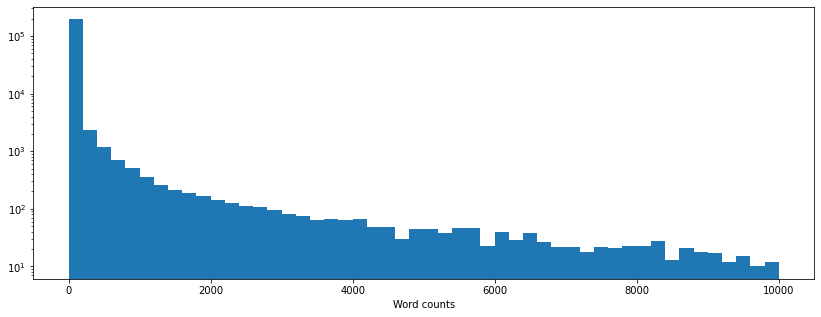

In [ ]:
# Let's see how many words are there for each count
plt.figure(figsize = (14, 5))
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for (token, count) in token_counts.items() if count >= min_count] # <YOUR CODE HERE>

In [16]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [17]:
# You have already done that ;)

token_to_id = {token: idx for idx, token in enumerate(tokens)}# <YOUR CODE HERE>

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [19]:
token_to_id.get("the", UNK)

30746

In [20]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])  # get the indexes for special tokens 

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """

    # if we have a list of strings in input we have to convert it to list of lists (the example bellow)
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    # In the all text we find the longest word and out matrix will has this size in dim_2    
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    # Fill the matrix with the values of PAD_IX index in token_to_id
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))

    # we put the index of word to matrix for every word in the sentence
    # if the sentence is shorter we put the UNK_IX  to matrix
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [21]:
list(map(str.split, data["Title"][::100000].values))


[['engineering', 'systems', 'analyst'],
 ['hr', 'assistant'],
 ['senior', 'ec', '&', 'i', 'engineer']]

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


In [22]:
# testing:
for item in ['engineering', 'systems', 'analyst']:
  print(token_to_id[item], end = " ")


10807 30161 2166 

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [23]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### Once again about embeddings

In [24]:
example_matrix = torch.LongTensor(as_matrix(data['Title'][::100000]))
example_matrix

tensor([[10807, 30161,  2166,     1,     1],
        [15020,  2844,     1,     1,     1],
        [27645, 10201,    16, 15215, 10804]])

<font color = "blue">Что такое embedding? По сути это есть умножение one_hot вектора на матрицу, 
что соответсвует тому что мы вытаскиваем из матрицу строку </font>

In [25]:
embedding_layer = nn.Embedding(len(tokens), 32) # получаем матрицу

# для каждого числа в example_matrix выбираем вектор с таким индексом из 
# embedding_layer

print(example_matrix.shape)
embedded_example = embedding_layer(example_matrix) 
embedded_example.shape

torch.Size([3, 5])


torch.Size([3, 5, 32])

Первая размерность - размер батча(3), вторая - ось времени, третья - число каналов(размер вектора для одного токена)


In [26]:
name, weight_matrix = list(embedding_layer.named_parameters())[0]
print(len(token_to_id))
name, weight_matrix.shape

34158


('weight', torch.Size([34158, 32]))

In [27]:
weight_matrix[10807]

tensor([ 0.1143, -0.3137,  1.4547,  1.0945, -0.3040,  0.5721,  0.6039,  0.9832,
         0.4040,  0.2638,  0.4847,  0.4242,  1.3105,  0.6752, -0.2007,  0.0528,
        -0.0388, -1.8329, -0.9354, -1.2121,  1.1872, -0.4987,  0.5276,  0.7882,
         0.6201, -1.9658,  0.3237, -1.1599, -1.5772,  0.3243,  1.8158, -0.3935],
       grad_fn=<SelectBackward0>)

In [28]:
embedded_example[0, 0]

tensor([ 0.1143, -0.3137,  1.4547,  1.0945, -0.3040,  0.5721,  0.6039,  0.9832,
         0.4040,  0.2638,  0.4847,  0.4242,  1.3105,  0.6752, -0.2007,  0.0528,
        -0.0388, -1.8329, -0.9354, -1.2121,  1.1872, -0.4987,  0.5276,  0.7882,
         0.6201, -1.9658,  0.3237, -1.1599, -1.5772,  0.3243,  1.8158, -0.3935],
       grad_fn=<SelectBackward0>)

In [29]:
embedded_example[0, 0].shape

torch.Size([32])

In [30]:
torch.allclose(weight_matrix[10807], embedded_example[0, 0])

True

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [31]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [32]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

Every row in text columns we replace with the vector where every word replace with his index in the tokens list. So in usually case we have that every feature charactirizes as a single number valus, but in this case every feature value - is the vector. We can say that every text feature in data replaces this 32 new features - embedding vector

In [33]:
a = make_batch(data_train[:3], max_len=10)
a

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]], dtype=int32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32),
 'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]], dtype=int32)}

#### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [34]:
# You will need these to make it simple

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))  # меняет порядок осей, в обычном 
                                         # сверточном слое мы сворачиваемся
                                         # по оси времени (свертка идет всегда вдоль последней оси)

In [35]:
reorder = Reorder()
print(embedded_example.shape)
print(reorder(embedded_example).shape)

torch.Size([3, 5, 32])
torch.Size([3, 32, 5])


To generate minibatches we will use simple pyton generator.

In [36]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [37]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [38]:
batch

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[24128, 30405, 26009, ...,     1,     1,     1],
        [28754,  6026,    82, ...,   197, 28756,    82],
        [20102, 31100, 12866, ...,     1,     1,     1]], dtype=int32),
 'Title': array([[24128, 30405, 26009, 15554, 30746, 30263,  2573,  2697],
        [28754,  6026,     1,     1,     1,     1,     1,     1],
        [ 6358, 21926,     1,     1,     1,     1,     1,     1]],
       dtype=int32)}

In [39]:
# Here is some startup code:
n_tokens=len(tokens)
n_cat_features=len(categorical_vectorizer.vocabulary_)
hid_size=64
print(f"n_tokens:        {n_tokens}")
print(f"n_cat_features:  {n_cat_features}")

n_tokens:        34158
n_cat_features:  3768


In [40]:
simple_model = nn.Sequential()

simple_model.add_module(
    'emb', nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size))

simple_model.add_module(
    'reorder', Reorder())

simple_model.add_module(
    "conv1", nn.Conv1d(in_channels=hid_size, out_channels=2*hid_size, 
                       kernel_size=3))

simple_model.add_module("relu1", nn.ReLU())

simple_model.add_module("bn1", nn.BatchNorm1d(2*hid_size))

simple_model.add_module(
    "conv2", nn.Conv1d(in_channels=2*hid_size, out_channels=2*hid_size, 
                       kernel_size=3))

simple_model.add_module("relu2", nn.ReLU())

simple_model.add_module("bn2", nn.BatchNorm1d(2*hid_size))


simple_model.add_module(
    "adaptive_pool", nn.AdaptiveMaxPool1d(1))

simple_model.add_module(
    "flatten", nn.Flatten())

simple_model.add_module(
    "out", nn.Linear(2*hid_size, 1))

# <YOUR CODE HERE>

__Remember!__ We are working with regression problem and predicting only one number.

In [ ]:
# Try this to check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch['FullDescription'], dtype=torch.long)).shape

torch.Size([3, 1])

In [41]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [ ]:
simple_model.to(device)

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptive_pool): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

And now simple training pipeline:

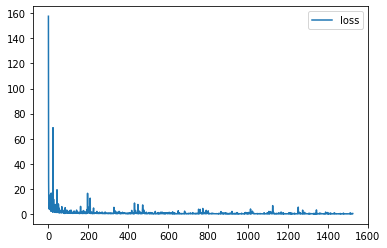

CPU times: user 5min 37s, sys: 2.79 s, total: 5min 40s
Wall time: 5min 42s


In [ ]:
%%time
from IPython.display import clear_output
from random import sample

epochs = 2

model = simple_model
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() # <YOUR CODE HERE>

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
        opt.zero_grad()
        # Preprocessing the batch data and target
        batch = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)


        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target)# <YOUR CODE HERE>

        # train with backprop
        # <YOUR CODE HERE>
        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx+1)%10==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()

To evaluate the model it can be switched to `eval` state.

In [ ]:
simple_model.eval()

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptive_pool): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

Let's check the model quality.

In [42]:
from tqdm import tqdm, tqdm_notebook
batch_size = 256
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in tqdm(iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)):
        batch = torch.tensor(batch_x['FullDescription'], dtype=torch.long).to(device)
        batch_pred = model(batch)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error

In [ ]:
print_metrics(simple_model, data_train, name='Train')
print_metrics(simple_model, data_val, name='Val');

765it [01:27,  8.71it/s]


Train results:
Mean square error: 0.22608
Mean absolute error: 0.35138


192it [00:21,  8.78it/s]

Val results:
Mean square error: 0.23093
Mean absolute error: 0.35475


In [ ]:
# Remember that we used log for target, so in usually scale we have that the error:
np.exp(0.23), np.exp(0.35475)

(1.2586000099294778, 1.4258241536823415)

### Bonus area: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [58]:
class ThreeInputsNet(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super(ThreeInputsNet, self).__init__()
        
        # title_part
        self.title_emb = nn.Embedding(n_tokens, embedding_dim=hid_size)
        # <YOUR CODE HERE>
        self.title_conv1 = nn.Conv1d(hid_size, 2*hid_size, 3)
        self.title_relu1 = nn.ReLU()
        self.title_bnorm1 = nn.BatchNorm1d(2*hid_size)
        
        self.title_conv2 = nn.Conv1d(2*hid_size, 2*hid_size, 2)
        self.title_relu2 = nn.ReLU()
        self.title_bnorm2 = nn.BatchNorm1d(2*hid_size)
        
        self.title_conv2 = nn.Conv1d(2*hid_size, hid_size, 2)
        self.title_relu2 = nn.ReLU()
        self.title_bnorm2 = nn.BatchNorm1d(hid_size)
        
        self.title_pool = nn.AdaptiveMaxPool1d(1)
        self.title_flatten = nn.Flatten()
        self.title_lin = nn.Linear(hid_size, 1)
        
        # embedding_part
        self.full_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        # <YOUR CODE HERE>
        self.full_conv1 = nn.Conv1d(hid_size, 2*hid_size, 3)
        self.full_relu1 = nn.ReLU()
        self.full_bnorm1 = nn.BatchNorm1d(2*hid_size)
        
        self.full_conv2 = nn.Conv1d(2*hid_size, 2*hid_size, 2)
        self.full_relu2 = nn.ReLU()
        self.full_bnorm2 = nn.BatchNorm1d(2*hid_size)
        
        self.full_conv2 = nn.Conv1d(2*hid_size, hid_size, 2)
        self.full_relu2 = nn.ReLU()
        self.full_bnorm2 = nn.BatchNorm1d(hid_size)
        
        self.full_pool = nn.AdaptiveMaxPool1d(1)
        self.full_flatten = nn.Flatten()
        self.full_lin = nn.Linear(hid_size, 1)
        
        
        # categorical_part
        self.category_lin1 = nn.Linear(n_cat_features, n_cat_features)# <YOUR CODE HERE>
        self.category_relu1 = nn.ReLU()
        self.category_bnorm1 = nn.BatchNorm1d(n_cat_features)
        self.category_out = nn.Linear(n_cat_features, 1)
        
        
        # final layer
        
        self.final = nn.Linear(3, 1)

    def forward(self, whole_input):
        input1, input2, input3 = whole_input
        
        # title_part
        title_beg = self.title_emb(input1).permute((0, 2, 1))
        title = self.title_conv1(title_beg) # <YOUR CODE HERE>
        title = self.title_relu1(title)
        title = self.title_bnorm1(title)
        
        title = self.title_conv2(title) # <YOUR CODE HERE>
        title = self.title_relu2(title)
        title = self.title_bnorm2(title)
        
        title = self.title_pool(title) # <YOUR CODE HERE>
        title = self.title_flatten(title)
        title_out = self.title_lin(title)
        
        # full_description_part
        full_beg = self.full_emb(input2).permute((0, 2, 1))     
        
        full = self.full_conv1(full_beg) # <YOUR CODE HERE>
        full = self.full_relu1(full)
        full = self.full_bnorm1(full)
        
        full = self.full_conv2(full) # <YOUR CODE HERE>
        full = self.full_relu2(full)
        full = self.full_bnorm2(full)
        
        full = self.full_pool(full) # <YOUR CODE HERE>
        full = self.full_flatten(full)
        full_out = self.full_lin(full)
        
        
        
        category = self.category_lin1(input3)# <YOUR CODE HERE>        
        category = self.category_relu1(category)
        category = self.category_bnorm1(category)
        category_out = self.category_out(category)
        concatenated = torch.cat(
            [
            title_out.view(title_out.size(0), -1),
            full_out.view(full_out.size(0), -1),
            category_out.view(category_out.size(0), -1)
            ],
            dim=1)
        
        out = self.final(concatenated) # <YOUR CODE HERE>
        
        return out

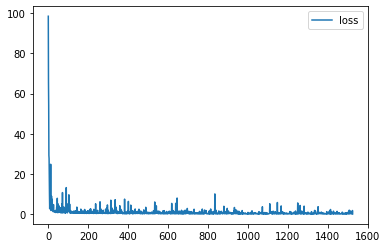

In [59]:
from IPython.display import clear_output
from random import sample

epochs = 2

model = ThreeInputsNet().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
        opt.zero_grad()

        # Preprocessing the batch data and target:
        batch = (
            torch.tensor(batch["Title"], dtype=torch.long).to(device),
            torch.tensor(batch["FullDescription"], dtype=torch.long).to(device),
            torch.tensor(batch["Categorical"], dtype=torch.float32).to(device),
        )
        target = torch.tensor(target).to(device)

        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target)

        # Train with backprop:
        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [60]:
batch_size = 256
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in tqdm(iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)):

        batch = (
            torch.tensor(batch_x["Title"], dtype=torch.long).to(device),
            torch.tensor(batch_x["FullDescription"], dtype=torch.long).to(device),
            torch.tensor(batch_x["Categorical"], dtype=torch.float32).to(device),
        )
        batch_pred = model(batch)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error

In [61]:
model.eval()
print_metrics(model, data_train, name="Train")
print_metrics(model, data_val, name="Val");

765it [00:45, 16.74it/s]


Train results:
Mean square error: 0.11587
Mean absolute error: 0.25497


192it [00:11, 17.34it/s]

Val results:
Mean square error: 0.13923
Mean absolute error: 0.28168


In [62]:
np.exp(0.13), np.exp(0.28)

(1.1388283833246218, 1.3231298123374369)

### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
# <YOUR CODE HERE>

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [ ]:
# <YOUR CODE HERE>

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)